In [52]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torchvision.utils import save_image


In [53]:

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create a directory if not exists
sample_dir = 'samples'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

# Hyper-parameters
image_size = 784
h_dim = 400
z_dim = 60
num_epochs = 30
batch_size = 64
learning_rate = 2e-3

# MNIST dataset
dataset = torchvision.datasets.KMNIST(root='../../data',
                                     train=True,
                                     transform=transforms.ToTensor(),
                                     download=True)

# Data loader
data_loader = torch.utils.data.DataLoader(dataset=dataset,
                                          batch_size=batch_size, 
                                          shuffle=True)


# VAE model
class VAE(nn.Module):
    def __init__(self, image_size=784, h_dim=400, z_dim=60):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(image_size, 500)
        self.fc2 = nn.Linear(500, 300)
        self.fc3 = nn.Linear(300, 150)
        self.fc4 = nn.Linear(150, z_dim)
        self.fc41 = nn.Linear(150, z_dim)
        self.fc5 = nn.Linear(z_dim, 150)
        self.fc6 = nn.Linear(150, 300)
        self.fc7 = nn.Linear(300, 500)
        self.fc8 = nn.Linear(500, image_size)
        
    def encode(self, x):
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        h = F.relu(self.fc3(h))
        return self.fc4(h), self.fc41(h)
    
    def reparameterize(self, mu, log_var):
        std = torch.exp(log_var/2)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = F.relu(self.fc5(z))
        h = F.relu(self.fc6(h))
        h = F.relu(self.fc7(h))
        return F.sigmoid(self.fc8(h))
    
    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        x_reconst = self.decode(z)
        return x_reconst, mu, log_var

model = VAE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Start training
for epoch in range(num_epochs):
    for i, (x, _) in enumerate(data_loader):
        # Forward pass
        x = x.to(device).view(-1, image_size)
        x_reconst, mu, log_var = model(x)
        
        # Compute reconstruction loss and kl divergence
        # For KL divergence, see Appendix B in VAE paper or http://yunjey47.tistory.com/43
        reconst_loss = F.binary_cross_entropy(x_reconst, x, size_average=False)
        kl_div = - 0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        
        # Backprop and optimize
        loss = reconst_loss + kl_div
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 200 == 0:
            print ("Epoch[{}/{}], Step [{}/{}], Reconst Loss: {:.4f}, KL Div: {:.4f}, TOTAL : {:.4f}" 
                   .format(epoch+1, num_epochs, i+1, len(data_loader), reconst_loss.item(), kl_div.item(), kl_div.item()+reconst_loss.item()))


/opt/conda/lib/python3.6/site-packages/torch/nn/functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/opt/conda/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch[1/30], Step [200/938], Reconst Loss: 19609.1641, KL Div: 438.3835, TOTAL : 20047.5476
Epoch[1/30], Step [400/938], Reconst Loss: 18509.8770, KL Div: 469.6022, TOTAL : 18979.4791
Epoch[1/30], Step [600/938], Reconst Loss: 18846.8340, KL Div: 456.1078, TOTAL : 19302.9418
Epoch[1/30], Step [800/938], Reconst Loss: 17524.1230, KL Div: 511.9526, TOTAL : 18036.0757
Epoch[2/30], Step [200/938], Reconst Loss: 16622.7852, KL Div: 535.4802, TOTAL : 17158.2654
Epoch[2/30], Step [400/938], Reconst Loss: 17441.1953, KL Div: 496.7946, TOTAL : 17937.9899
Epoch[2/30], Step [600/938], Reconst Loss: 16753.7891, KL Div: 545.9357, TOTAL : 17299.7248
Epoch[2/30], Step [800/938], Reconst Loss: 15497.2988, KL Div: 561.3926, TOTAL : 16058.6914
Epoch[3/30], Step [200/938], Reconst Loss: 15446.8750, KL Div: 603.1707, TOTAL : 16050.0457
Epoch[3/30], Step [400/938], Reconst Loss: 15690.5889, KL Div: 651.0436, TOTAL : 16341.6324
Epoch[3/30], Step [600/938], Reconst Loss: 16552.4980, KL Div: 618.1237, TOTAL :

Epoch[23/30], Step [400/938], Reconst Loss: 12716.3477, KL Div: 829.8295, TOTAL : 13546.1772
Epoch[23/30], Step [600/938], Reconst Loss: 14114.1133, KL Div: 852.9409, TOTAL : 14967.0541
Epoch[23/30], Step [800/938], Reconst Loss: 12012.3057, KL Div: 812.5269, TOTAL : 12824.8326
Epoch[24/30], Step [200/938], Reconst Loss: 13563.8438, KL Div: 857.0262, TOTAL : 14420.8699
Epoch[24/30], Step [400/938], Reconst Loss: 12631.9805, KL Div: 828.7588, TOTAL : 13460.7393
Epoch[24/30], Step [600/938], Reconst Loss: 14019.6523, KL Div: 842.1604, TOTAL : 14861.8127
Epoch[24/30], Step [800/938], Reconst Loss: 14006.7910, KL Div: 815.0608, TOTAL : 14821.8518
Epoch[25/30], Step [200/938], Reconst Loss: 13507.3867, KL Div: 833.0582, TOTAL : 14340.4449
Epoch[25/30], Step [400/938], Reconst Loss: 12886.6816, KL Div: 836.1169, TOTAL : 13722.7985
Epoch[25/30], Step [600/938], Reconst Loss: 12908.9375, KL Div: 834.4130, TOTAL : 13743.3505
Epoch[25/30], Step [800/938], Reconst Loss: 14187.6953, KL Div: 810.73

In [54]:
with torch.no_grad():
    # Save the sampled images
    z = torch.randn(batch_size, z_dim).to(device)
    out = model.decode(z).view(-1, 1, 28, 28)


/opt/conda/lib/python3.6/site-packages/torch/nn/functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [55]:
out = out.cpu().numpy()

In [56]:
import matplotlib.pyplot as plt

In [57]:
out = out.reshape(-1, 28, 28)

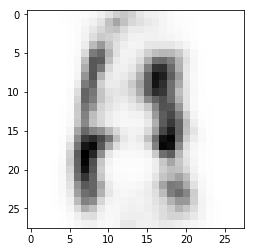

In [76]:
plt.imshow(out[1], cmap='Greys')

In [78]:
for epoch in range(num_epochs):
    for i, (x, _) in enumerate(data_loader):
        # Forward pass
        x = x.to(device).view(-1, image_size)
        x_reconst, mu, log_var = model(x)
        
        # Compute reconstruction loss and kl divergence
        # For KL divergence, see Appendix B in VAE paper or http://yunjey47.tistory.com/43
        reconst_loss = F.binary_cross_entropy(x_reconst, x, size_average=False)
        kl_div = - 0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        
        # Backprop and optimize
        loss = reconst_loss + 0.8*kl_div
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 200 == 0:
            print ("Epoch[{}/{}], Step [{}/{}], Reconst Loss: {:.4f}, KL Div: {:.4f}, TOTAL : {:.4f}" 
                   .format(epoch+1, num_epochs, i+1, len(data_loader), reconst_loss.item(), kl_div.item(), kl_div.item()+reconst_loss.item()))


/opt/conda/lib/python3.6/site-packages/torch/nn/functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/opt/conda/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch[1/30], Step [200/938], Reconst Loss: 13473.8184, KL Div: 824.1640, TOTAL : 14297.9824
Epoch[1/30], Step [400/938], Reconst Loss: 13602.9609, KL Div: 821.0224, TOTAL : 14423.9833
Epoch[1/30], Step [600/938], Reconst Loss: 13949.1582, KL Div: 806.6505, TOTAL : 14755.8087
Epoch[1/30], Step [800/938], Reconst Loss: 13664.4570, KL Div: 771.9769, TOTAL : 14436.4340
Epoch[2/30], Step [200/938], Reconst Loss: 13882.6465, KL Div: 789.9166, TOTAL : 14672.5631
Epoch[2/30], Step [400/938], Reconst Loss: 12918.0078, KL Div: 791.8185, TOTAL : 13709.8263
Epoch[2/30], Step [600/938], Reconst Loss: 12952.6016, KL Div: 826.9355, TOTAL : 13779.5371
Epoch[2/30], Step [800/938], Reconst Loss: 14227.3320, KL Div: 819.3240, TOTAL : 15046.6560


KeyboardInterrupt: 

In [79]:
for epoch in range(num_epochs):
    for i, (x, _) in enumerate(data_loader):
        # Forward pass
        x = x.to(device).view(-1, image_size)
        x_reconst, mu, log_var = model(x)
        
        # Compute reconstruction loss and kl divergence
        # For KL divergence, see Appendix B in VAE paper or http://yunjey47.tistory.com/43
        reconst_loss = F.binary_cross_entropy(x_reconst, x, size_average=False)
        kl_div = - 0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        
        # Backprop and optimize
        loss = reconst_loss + 0.8*kl_div
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 200 == 0:
            print ("Epoch[{}/{}], Step [{}/{}], Reconst Loss: {:.4f}, KL Div: {:.4f}, TOTAL : {:.4f}" 
                   .format(epoch+1, num_epochs, i+1, len(data_loader), reconst_loss.item(), kl_div.item(), kl_div.item()+reconst_loss.item()))


/opt/conda/lib/python3.6/site-packages/torch/nn/functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/opt/conda/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch[1/30], Step [200/938], Reconst Loss: 13912.3730, KL Div: 891.7874, TOTAL : 14804.1605
Epoch[1/30], Step [400/938], Reconst Loss: 13598.3916, KL Div: 877.1481, TOTAL : 14475.5397
Epoch[1/30], Step [600/938], Reconst Loss: 14627.7041, KL Div: 861.9656, TOTAL : 15489.6697
Epoch[1/30], Step [800/938], Reconst Loss: 12950.8887, KL Div: 862.4142, TOTAL : 13813.3029
Epoch[2/30], Step [200/938], Reconst Loss: 13240.3145, KL Div: 888.4674, TOTAL : 14128.7819
Epoch[2/30], Step [400/938], Reconst Loss: 13235.0225, KL Div: 876.6308, TOTAL : 14111.6533
Epoch[2/30], Step [600/938], Reconst Loss: 13418.5068, KL Div: 885.6481, TOTAL : 14304.1549
Epoch[2/30], Step [800/938], Reconst Loss: 13009.3223, KL Div: 875.0283, TOTAL : 13884.3505
Epoch[3/30], Step [200/938], Reconst Loss: 13234.9863, KL Div: 901.3415, TOTAL : 14136.3278
Epoch[3/30], Step [400/938], Reconst Loss: 14719.3535, KL Div: 870.2368, TOTAL : 15589.5903
Epoch[3/30], Step [600/938], Reconst Loss: 13414.0576, KL Div: 895.2520, TOTAL :

Epoch[23/30], Step [400/938], Reconst Loss: 13802.7969, KL Div: 905.1202, TOTAL : 14707.9171
Epoch[23/30], Step [600/938], Reconst Loss: 13649.5654, KL Div: 918.8653, TOTAL : 14568.4307
Epoch[23/30], Step [800/938], Reconst Loss: 12942.3691, KL Div: 907.5715, TOTAL : 13849.9407
Epoch[24/30], Step [200/938], Reconst Loss: 13012.0635, KL Div: 897.7147, TOTAL : 13909.7782
Epoch[24/30], Step [400/938], Reconst Loss: 12592.4932, KL Div: 916.9952, TOTAL : 13509.4884
Epoch[24/30], Step [600/938], Reconst Loss: 13066.1992, KL Div: 932.1506, TOTAL : 13998.3498
Epoch[24/30], Step [800/938], Reconst Loss: 13383.7539, KL Div: 889.3903, TOTAL : 14273.1442
Epoch[25/30], Step [200/938], Reconst Loss: 12791.3057, KL Div: 878.2718, TOTAL : 13669.5775
Epoch[25/30], Step [400/938], Reconst Loss: 13201.4541, KL Div: 902.1658, TOTAL : 14103.6199
Epoch[25/30], Step [600/938], Reconst Loss: 13489.7432, KL Div: 920.3289, TOTAL : 14410.0721
Epoch[25/30], Step [800/938], Reconst Loss: 13894.0059, KL Div: 906.24

KeyboardInterrupt: 

/opt/conda/lib/python3.6/site-packages/torch/nn/functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


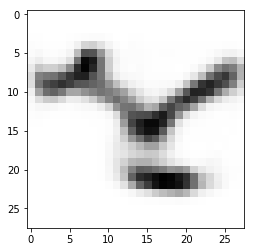

In [92]:
plt.imshow(out[25], cmap='Greys')

/opt/conda/lib/python3.6/site-packages/torch/nn/functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


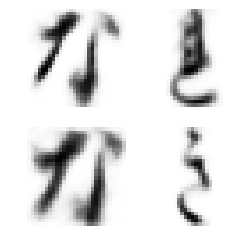

In [203]:
with torch.no_grad():
    # Save the sampled images
    z = torch.randn(batch_size, z_dim).to(device)
    out = model.decode(z).view(-1, 1, 28, 28)
out = out.reshape(-1, 28,28)
import matplotlib.pyplot as plt
from pylab import * 
rangee = 3
for k in range(1, rangee):
    subplot(2, rangee, k)
    plt.axis('off')
    imshow(out[k], cmap='Greys')
    subplot(2, rangee, k+rangee)
    imshow(out[k+rangee], cmap='Greys')
    plt.axis('off')   
    

In [204]:
l = []
for i, (x, _) in enumerate(data_loader):
    l.append(x)
    if i==20:
        break


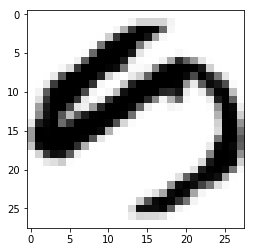

In [247]:
a = l[10].cpu().numpy()
a  = np.squeeze(a[9], axis=0)
plt.imshow(a, cmap='Greys')

In [218]:
test = l[0]


ValueError: cannot select an axis to squeeze out which has size not equal to one

In [240]:
with torch.no_grad():
    x= l[10]
    # Save the sampled images
    x = x.to(device).view(-1, image_size)
    x_reconst, mu, log_var = model(x)
# out = out.reshape(-1, 28,28)
# import matplotlib.pyplot as plt
# from pylab import * 
# rangee = 3
# for k in range(1, rangee):
#     subplot(2, rangee, k)
#     plt.axis('off')
#     imshow(out[k], cmap='Greys')
#     subplot(2, rangee, k+rangee)
#     imshow(out[k+rangee], cmap='Greys')
#     plt.axis('off')   
    

/opt/conda/lib/python3.6/site-packages/torch/nn/functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [241]:
x_reconst = x_reconst.reshape(64, 28, 28)

In [242]:
x_reconst = x_reconst.cpu().numpy()

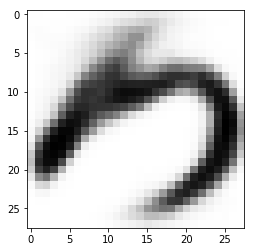

In [248]:
plt.imshow(x_reconst[9], cmap='Greys')